# Projekt 2

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.under_sampling import NearMiss
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.stats.contingency import association
from sklearn.cluster import DBSCAN, KMeans
from sklearn.impute import KNNImputer
from sklearn.manifold import MDS
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn_extra.cluster import KMedoids

In [2]:
np.random.seed(13)
sns.set_theme(style='whitegrid')

In [3]:
# An improvement upon KNNImputer found in sklearn.
class BetterKNNImputer(KNNImputer):
    def __init__(
        self,
        numeric_cols: list,
        categorical_cols: list,
        target_col: str,
        is_target_numeric=True,
    ):
        self.numeric_cols = [col for col in numeric_cols if col != target_col]
        self.categorical_cols = [col for col in categorical_cols if col != target_col]
        self.target_col = target_col
        self.is_target_numeric = is_target_numeric
        
        self.numeric_transformer = StandardScaler()
        self.categorical_transformer = OneHotEncoder(handle_unknown='ignore')
        
        if is_target_numeric:
            self.target_transformer = StandardScaler()
            self.undersampler = None
        else:
            self.target_transformer = OneHotEncoder(handle_unknown='ignore')
            # NearMiss-1 seems to do well here.
            self.undersampler = NearMiss()
            
        super().__init__()
        self.weights = 'distance'

    def _preprocess_data_fit(
        self,
        X: pd.DataFrame,
    ) -> tuple[pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray]:
        # Extract the column of interest from X.
        target = X[[self.target_col]].copy()
        X = X.drop(self.target_col, axis=1)
        
        # Standardize numeric columns.
        X[self.numeric_cols] = self.numeric_transformer.fit_transform(
            X[self.numeric_cols]
        )
        
        # Perform One Hot Encoding on categorical variables.
        categorical_dummies = self.categorical_transformer.fit_transform(
            X[self.categorical_cols]
        )
        categorical_features = self.categorical_transformer.get_feature_names_out()
        categorical_dummies = pd.DataFrame(
            data=categorical_dummies.toarray(),
            columns=categorical_features,
        )
        
        categorical_features = [
            col for col in categorical_features if not col.endswith('nan')
        ]
        categorical_dummies = categorical_dummies[categorical_features]
        
        # Concat X so everything in it is encoded.
        X = X.drop(self.categorical_cols, axis=1)
        X = pd.concat([X.reset_index(drop=True), categorical_dummies], axis=1)

        # Perform undersampling if target variable is categorical.
        X_mask = ~X.isna().any(axis=1).to_numpy()
        old_target_mask = ~target.isna().any(axis=1).to_numpy()
        X_target_mask = X_mask & old_target_mask
        if not self.is_target_numeric:
            X_undersampled, target_undersampled = self.undersampler.fit_resample(
                X[X_target_mask],
                target[X_target_mask],
            )
            X = pd.concat([X[~X_target_mask], X_undersampled])
            target = pd.concat([target[~X_target_mask], target_undersampled])

        # Make sure index for X isn't nonsense.
        X = X.reset_index(drop=True)

        # Mask is useful for fitting.
        new_target_mask = ~target.isna().any(axis=1).to_numpy()
        # Transform the target variable.
        target = self.target_transformer.fit_transform(target)
        
        return X, target, new_target_mask

    def _preprocess_data_transform(
        self,
        X: pd.DataFrame,
    ) -> tuple[pd.DataFrame, pd.DataFrame, np.ndarray]:
        # Extract the column of interest from X.
        target = X[[self.target_col]].copy()
        X = X.drop(self.target_col, axis=1)

        # Standardize numeric columns.
        X[self.numeric_cols] = self.numeric_transformer.transform(
            X[self.numeric_cols]
        )

        # Perform One Hot Encoding on categorical variables.
        categorical_dummies = self.categorical_transformer.transform(
            X[self.categorical_cols]
        )
        categorical_features = self.categorical_transformer.get_feature_names_out()
        categorical_dummies = pd.DataFrame(
            data=categorical_dummies.toarray(),
            columns=categorical_features,
        )
        categorical_features = [
            col for col in categorical_features if not col.endswith('nan')
        ]
        categorical_dummies = categorical_dummies[categorical_features]

        # Concat X so everything in it is encoded.
        X = X.drop(self.categorical_cols, axis=1)
        X = pd.concat([X.reset_index(drop=True), categorical_dummies], axis=1)

        # Mask is useful for transforming.
        target_mask = ~target.isna().any(axis=1).to_numpy()
        # Transform the target variable.
        target = self.target_transformer.transform(target)
        
        return X, target, target_mask

    def fit(self, X: pd.DataFrame):
        X, target, new_target_mask = self._preprocess_data_fit(X)

        if self.is_target_numeric:
            target = pd.DataFrame(data=target, columns=[self.target_col])
            X = pd.concat([X, target], axis=1)
        else:
            target_features = self.target_transformer.get_feature_names_out()
            target = pd.DataFrame(data=target.toarray(),columns=target_features)
            target_features = [
                col for col in target_features if not col.endswith('nan')
            ]
            target = target[target_features]
            # Makes it so missing columns are actually read as such.
            target[~new_target_mask] = np.nan
            X = pd.concat([X, target], axis=1)

        # Set n_neighbors using a heuristic.
        self.n_neighbors = int(len(target) ** 0.5)
        
        return super().fit(X)

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        new_data = X.copy()
        X, target, target_mask = self._preprocess_data_transform(X)

        if self.is_target_numeric:
            target = pd.DataFrame(data=target, columns=[self.target_col])
            X = pd.concat([X, target], axis=1)
            new_target = super().transform(X)[:, [-1]]
            new_target = self.target_transformer.inverse_transform(new_target)[:, 0]
            new_data[self.target_col] = new_target
        else:
            target_features = self.target_transformer.get_feature_names_out()
            target = pd.DataFrame(data=target.toarray(), columns=target_features)
            target_features = [
                col for col in target_features if not col.endswith('nan')
            ]
            target = target[target_features]
            # Makes it so missing columns are actually read as such.
            target[~target_mask] = np.nan
            
            X = pd.concat([X, target], axis=1)
            new_target = super().transform(X)[:, (-len(target_features)):]
            new_target = self.target_transformer.categories_[0][
                np.argmax(new_target, axis=1)
            ]
            new_data[self.target_col] = new_target
        
        return new_data

def cramerv(var1: np.ndarray, var2: np.ndarray) -> float:
    crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
    return association(crosstab)

## Załadowanie danych

Wybrane dane dotyczą płatków z mlekiem. Będziemy chcieli obserwacje podzielić na klastry. 

Zawierają one zmienne ilościowe:

1. **calories** - ilość kcal w porcji,
2. **protein** - ilość białka w porcji (g),
3. **fat** - ilość tłuszczu w porcji (g),
4. **sodium** - ilość soli w porcji (mg),
5. **fiber** - ilość błonnika w porcji (g),
6. **carbo** - ilość złożonych węglowodanów w porcji (g),
7. **sugars** - ilość cukrów w porcji (g),
8. **potass** - ilość potasu w porcji (mg),
9. **vitamins** - typowy procent zaspokojenia potrzeby dla kluczowych witamin i minerałów ustalonej przez FDA,
10. **weight** - waga porcji w uncjach,
11. **cups** - objętość porcji w szklankach,
12. **rating** - Ocena w skali 0-100 obliczona przez Consumer Reports.

Zawierają one zmienne kategoryczne:

1. **mfr** - producent płatków z mlekiem (zmienna nominalna):
   - A - American Home Food Products,
   - G - General Mills,
   - K - Kellogs,
   - N - Nabisco,
   - P - Post,
   - Q - Quaker Oats,
   - R - Ralston Purina;

2. **type** - czy podawane na zimno czy ciepło (zmienna nominalna):
   - C - zimno,
   - H - ciepło;

3. **shelf** - na jakiej półce są wystawione (zmienna porządkowa):
   - 1 - najbliższa podłogi,
   - 2 - druga od podłogi,
   - 3 - trzecia od podłogi;


In [4]:
data = pd.read_excel('Cereals.xls')
data.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100%_Bran,N,C,70,4,1,130,10.0,5.0,6.0,280.0,25,3,1.0,0.33,68.402973
1,100%_Natural_Bran,Q,C,120,3,5,15,2.0,8.0,8.0,135.0,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5.0,320.0,25,3,1.0,0.33,59.425505
3,All-Bran_with_Extra_Fiber,K,C,50,4,0,140,14.0,8.0,0.0,330.0,25,3,1.0,0.50,93.704912
4,Almond_Delight,R,C,110,2,2,200,1.0,14.0,8.0,NaN,25,3,1.0,0.75,34.384843


In [5]:
display(data.shape)
display(data.dtypes)

(77, 16)

name         object
mfr          object
type         object
calories      int64
protein       int64
fat           int64
sodium        int64
fiber       float64
carbo       float64
sugars      float64
potass      float64
vitamins      int64
shelf         int64
weight      float64
cups        float64
rating      float64
dtype: object

## Modyfikacje bazowego zbioru danych

Istotnie, jak było wspomniane wyżej, w zbiorze danych występuje zmienna **weight** opisująca wielkość porcji oraz **cups** opisująca objętość. Rozsądniej będzie rozważać wartości odżywcze na uncję, a nie nieujednoliconą porcję. Usunięto ze zbioru danych również zmienne **weight** oraz **cups** po dokonaniu tych transformacji.

In [6]:
numeric_cols = [
    'calories',
    'protein',
    'fat',
    'sodium',
    'vitamins',
    'fiber',
    'carbo',
    'sugars',
    'potass',
    'rating',
]
categorical_cols = [
    'mfr',
    'type',
    'shelf',
]

In [7]:
data_scaled = data.copy()
for col in numeric_cols:
    if col != 'rating':
        data[col] = data[col] / data['weight']
data_scaled = data.drop(['weight', 'cups'], axis=1)

## EDA

### Zmienne ilościowe

W pierwszej kolejności zbadano zmienne ilościowe. Najpierw obliczono dla nich statystyki opisowe.

In [8]:
data_scaled[numeric_cols].describe()

,calories,protein,fat,sodium,vitamins,fiber,carbo,sugars,potass,rating
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,76.000000,76.000000,75.000000,77.000000
mean,103.996910,2.490851,0.967279,153.356701,26.873265,2.052066,14.625548,6.654904,93.870188,42.665705
std,13.851864,1.084322,0.983707,82.768011,20.511148,2.302014,4.229837,4.093540,63.638932,14.047289
min,50.000000,1.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,20.000000,18.042851
25%,100.000000,2.000000,0.000000,125.000000,25.000000,1.000000,11.458333,3.000000,42.500000,33.174094
50%,106.666667,2.255639,1.000000,157.894737,25.000000,1.538462,14.000000,6.007519,90.000000,40.400208
75%,110.000000,3.000000,1.333333,200.000000,25.000000,3.000000,17.000000,10.000000,114.728916,50.828392
max,150.000000,6.000000,5.000000,320.000000,100.000000,14.000000,26.000000,15.000000,330.000000,93.704912


Widoczne jest, że w zmiennych **carbo**, **sugars** i **potass** występują wartości brakujące. Zostaną one rozważone dokładniej później. Na pierwszy rzut oka w niektorych zmiennych mogą występować wartości odstające, ale będzie to bardziej widoczne później na wykresach pudełkowych. Na ten moment rozsądnie będzie rozważyć korelację liniową między zmiennymi, aby się upewnić, że nie mierzą one dokładnie tego samego.

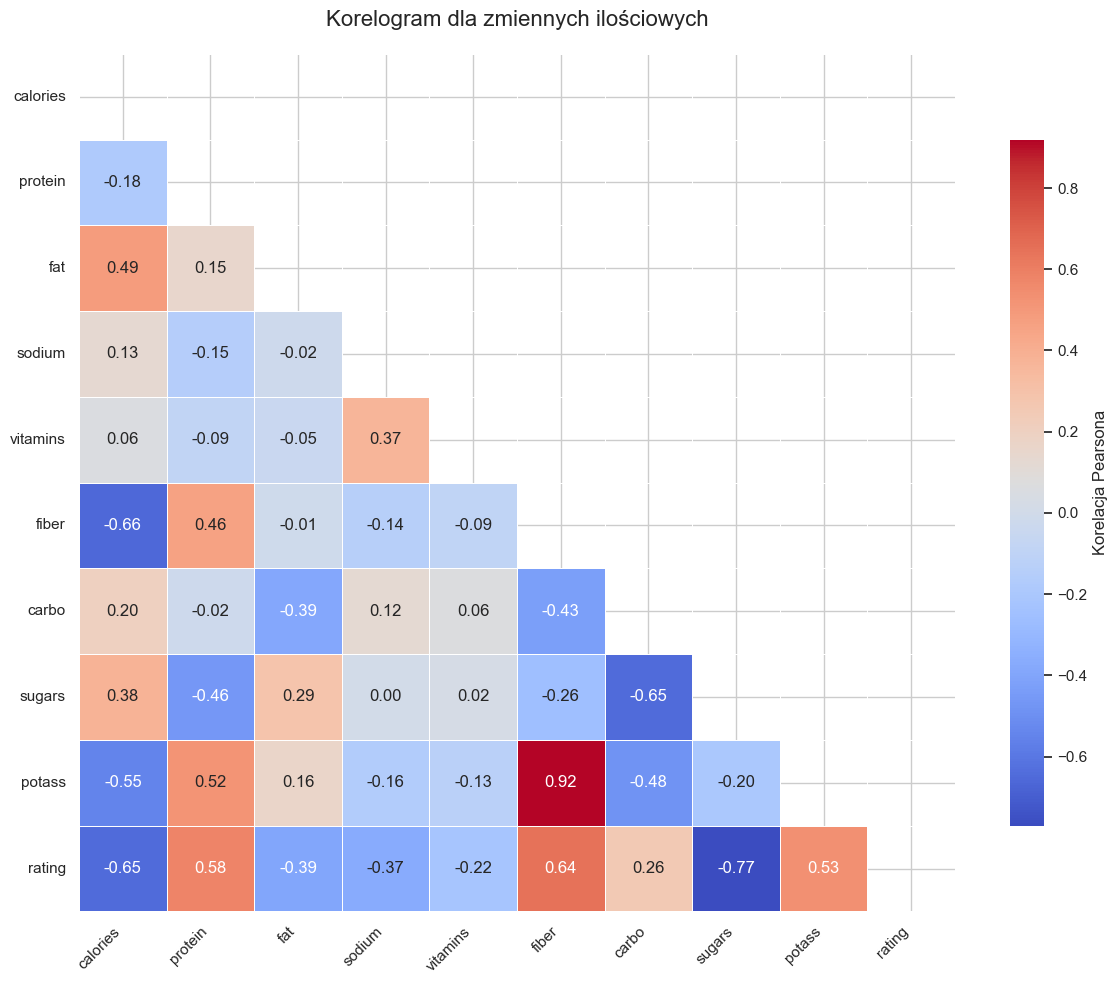

In [9]:
corr = data_scaled[numeric_cols].corr()
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr,
    mask=mask,
    annot=True,    
    fmt='.2f',         
    cmap='coolwarm',   
    linewidths=0.5,   
    cbar_kws={'shrink': .8, 'label': 'Korelacja Pearsona'}
)

plt.title('Korelogram dla zmiennych ilościowych', fontsize=16, pad=20)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Łatwo zauważyć, że ilość potasu i ilość błonnika są mocno skorelowane (korelacja na moduł większa niż 0.9). Nawet jeżeli te dwie zmienne mają wysoką korelację, to i tak obie można uznać za istotne pod kątem zróżnicowania płatków z mlekiem. Mierzą one ewidentnie dwie różne rzeczy mimo, że występuje tutaj silna zależność liniowa.

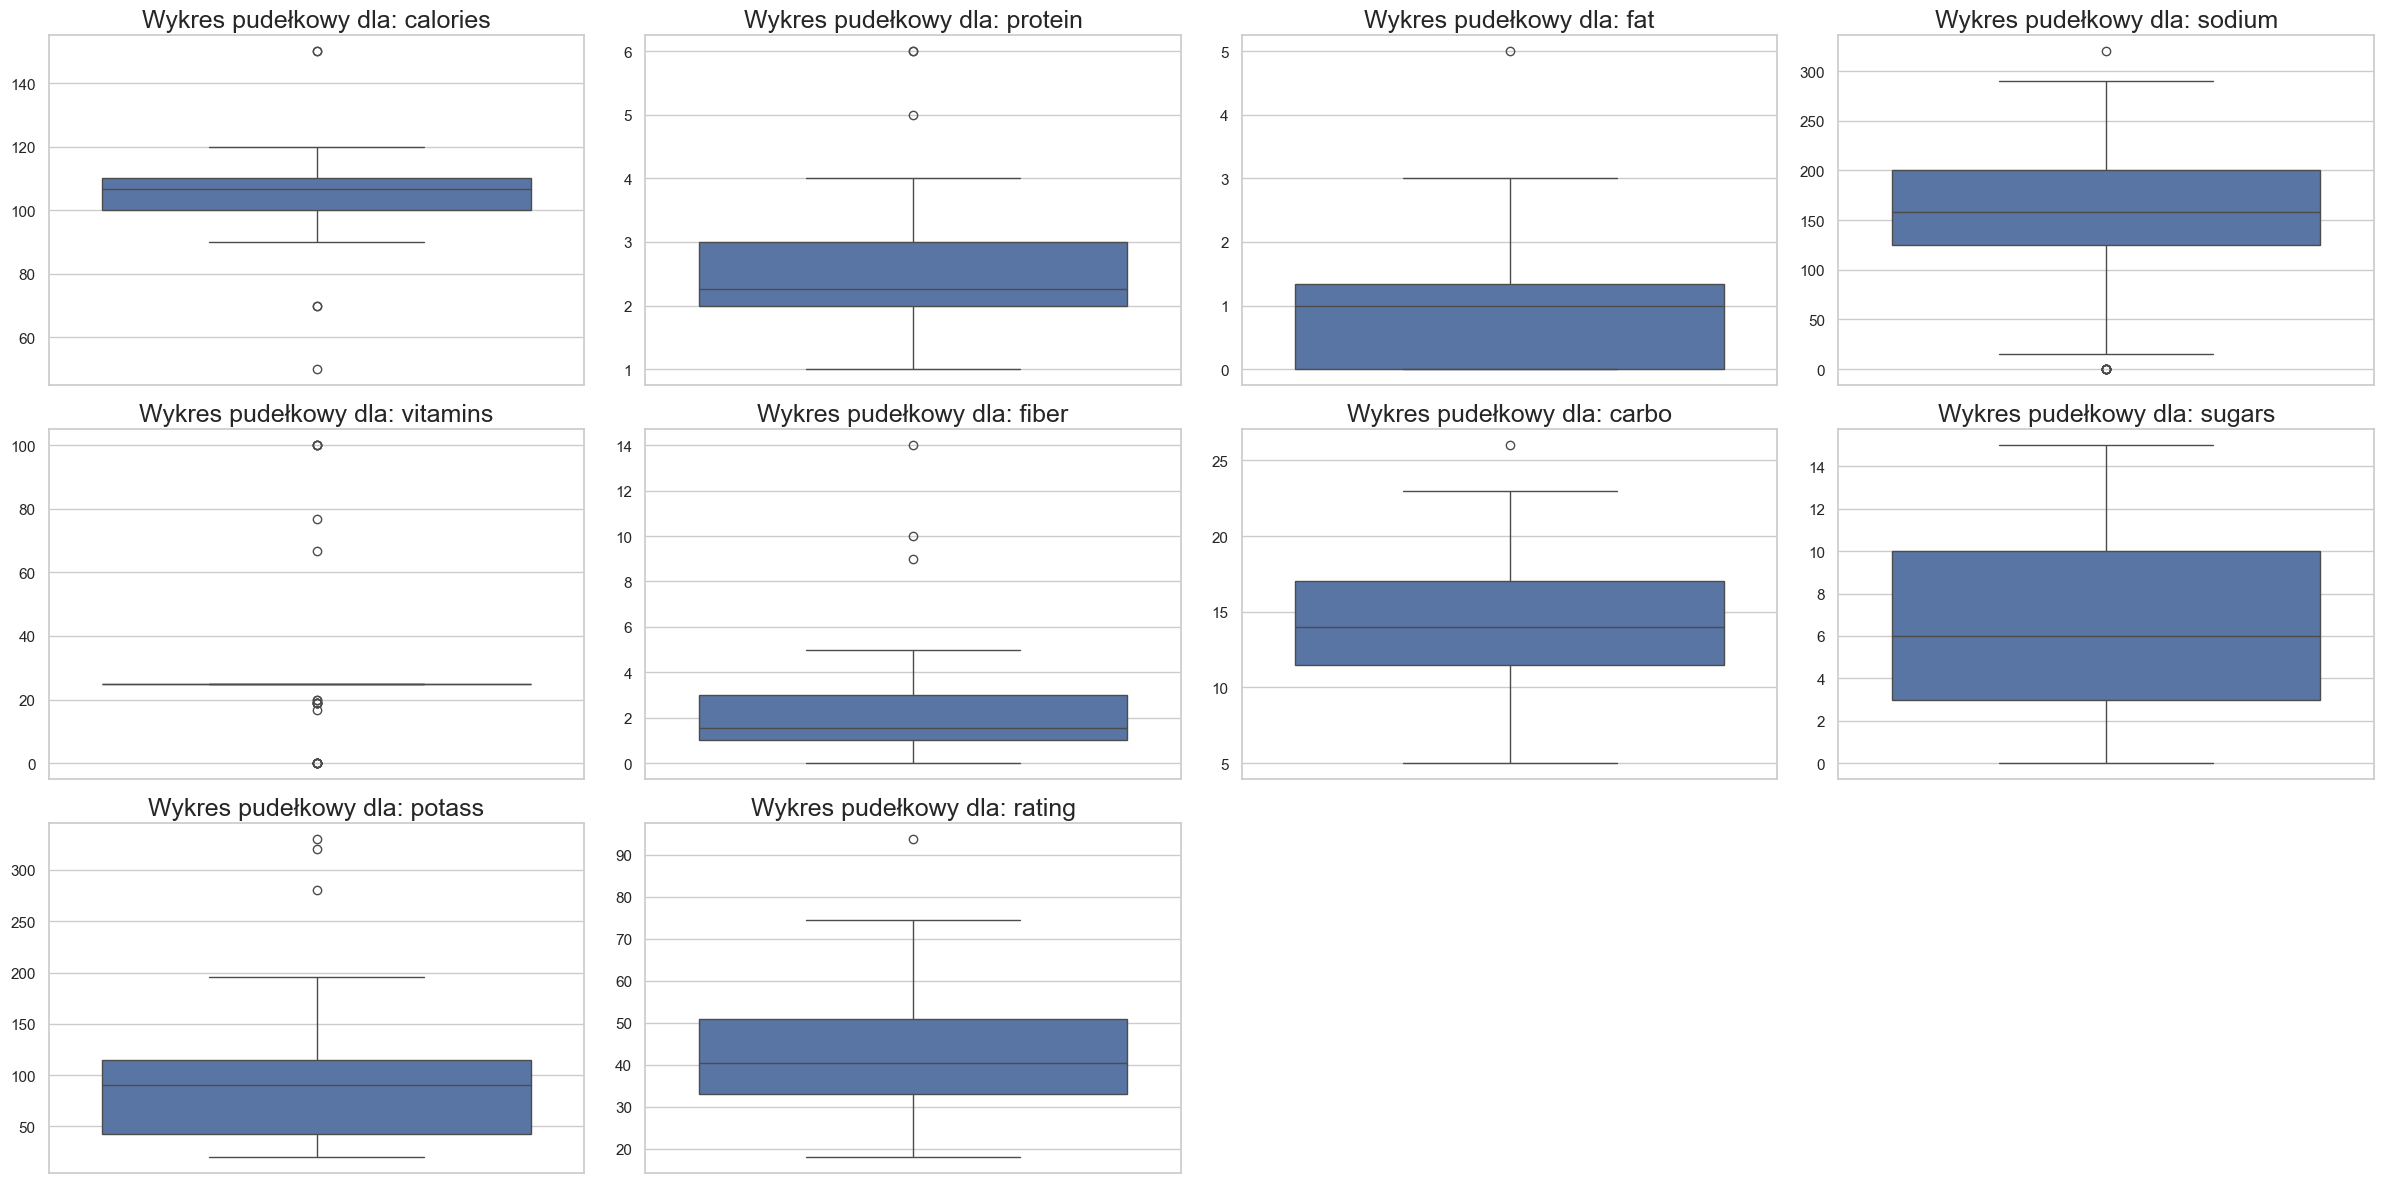

In [10]:
n_cols = 4 
n_plots = len(numeric_cols)
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))

axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(y=data_scaled[col], ax=axes[i])
    axes[i].set_title(f"Wykres pudełkowy dla: {col}", fontsize=18)
    axes[i].set_ylabel(None)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Widoczna jest duża liczba wartości odstających dla zmiennych. Nie wynikają one raczej z błędu pomiaru czy złego wprowadzenia danych, a raczej z samego charakteru tych zmiennych. Nie jest rozsądne te obserwacje usuwać, ale ich istnieje może sugerować, że metody bardziej podatne na wartości odstające takie jak *k-średnich* mogą nie działać zbyt dobrze. Usunięta zostanie zmienna **vitamins**, ze względu na jej zbyt małą zmienność (IQR jest równe 0).

In [11]:
data_transformed = data_scaled.copy()
data_transformed = data_transformed.drop('vitamins', axis=1)

### Zmienne kategoryczne

Zbadano także zmienne kategoryczne. Rozpoczęto od sprawdzenia liczności klas.

In [12]:
for col in categorical_cols:
    display(pd.DataFrame(data_scaled[col].value_counts(normalize=True)))

,proportion
mfr,
K,0.298701
G,0.285714
P,0.116883
Q,0.103896
R,0.103896
N,0.077922
A,0.012987


,proportion
type,
C,0.961039
H,0.038961


,proportion
shelf,
3,0.467532
2,0.272727
1,0.259740


W **mfr** oraz **type** występują kategorie o bardzo niskiej liczności. W przypadku **mfr** rozsądne będzie pogrupować wszystkie obserwacje oprócz 'K' i 'G' w 'Other'. W przypadku zmiennej **type** jedynie 3 obserwacje mają wartość 'H'. Niestety ta liczba jest zbyt mała, więc należy usunąć tą zmienną z analizy.

In [13]:
common_categories = ['K', 'G']
data_transformed['mfr'] = data_transformed['mfr'].apply(lambda x: x if x in common_categories else 'Other')
data_transformed = data_transformed.drop(['type'], axis=1)
categorical_cols_new = [
    'mfr',
    'shelf',
]

Na koniec policzono V-Cramera dla 2 pozostałych zmiennych kategorycznych.

In [14]:
number_of_cat_variables = len(categorical_cols_new)
cramer_summary = pd.DataFrame(
    np.zeros((number_of_cat_variables, number_of_cat_variables)),
    index=categorical_cols_new, columns=categorical_cols_new,
)
    
for i, col1 in enumerate(categorical_cols_new):
    for col2 in categorical_cols_new[i:]:
        v = cramerv(data_transformed[col1], data_transformed[col2])
        cramer_summary.at[col1, col2] = v
        cramer_summary.at[col2, col1] = v

display(cramer_summary)

,mfr,shelf
mfr,1.000000,0.111301
shelf,0.111301,1.000000


Pozostałe 2 zmienne kategorycze nie wykazują zbyt dużej zależności między sobą, gdyby ta zależność była zbyt duża, to wtedy trzeba by było rozważyć czy nie mierzą one tego samego. Warto zauważyć, że **shelf** jest zmienną porządkowową, więc nie należy jej kodować za pomocą *OneHotEncoding*.

### Brakujące dane

Zobaczmy jeszcze jak wyglądają wartości brakujące w rozważanym zbiorze danym

In [15]:
display(pd.DataFrame(data_transformed.isna().sum(), columns=['missing']))
missing_mask = data_transformed.isna().any(axis=1)
missing_indexes = data_transformed.index[missing_mask].tolist()
print('Rows with missing values:', missing_indexes)

missing_rows = data_transformed.loc[missing_mask]
display(missing_rows)

,missing
name,0
mfr,0
calories,0
protein,0
fat,0
sodium,0
fiber,0
carbo,1
sugars,1
potass,2


Rows with missing values: [4, 20, 57]


,name,mfr,calories,protein,fat,sodium,fiber,carbo,sugars,potass,shelf,rating
4,Almond_Delight,Other,110.0,2.0,2.0,200.0,1.0,14.0,8.0,NaN,3,34.384843
20,Cream_of_Wheat_(Quick),Other,100.0,3.0,0.0,80.0,1.0,21.0,0.0,NaN,2,64.533816
57,Quaker_Oatmeal,Other,100.0,5.0,2.0,0.0,2.7,NaN,NaN,110.0,1,50.828392


Występują 3 obserwacje, które mają wartości brakujące. Wartości zmiennych nie wydawają się być zbyt odległe od tych zaobserwowanych na reszcie zbioru danych. Nie znaleziono powodu, żeby ich nie uznać za MCAR albo MAR. Braki zostaną zaimputowane metodą KKNN.

## Budowanie modeli

Można teraz przejść do faktycznej budowy modeli.

In [16]:
data_train = data_transformed.set_index('name')
numeric_cols_train = [
    'calories',
    'protein',
    'fat',
    'sodium',
    'fiber',
    'carbo',
    'sugars',
    'potass',
    'rating',
]
categorical_cols_train = [
    'mfr',
]

### Imputacja wartości brakujących

Imputacja została dokonana za pomocą KNN. Zrobiono to dla danych zestandaryzowanych i odpowiednio zakodowanych zmiennych kategorycznych (jakościową i porządkową).

In [17]:
imputer_carbo = BetterKNNImputer(
    numeric_cols_train,
    categorical_cols_train,
    'carbo',
    is_target_numeric=True,
)
imputer_sugars = BetterKNNImputer(
    numeric_cols_train,
    categorical_cols_train,
    'sugars',
    is_target_numeric=True,
)
imputer_potass = BetterKNNImputer(
    numeric_cols_train,
    categorical_cols_train,
    'potass',
    is_target_numeric=True,
)
data_train['carbo'] = imputer_carbo.fit_transform(data_train)['carbo']
data_train['sugars'] = imputer_sugars.fit_transform(data_train)['sugars']
data_train['potass'] = imputer_potass.fit_transform(data_train)['potass']

In [18]:
data_train.iloc[missing_indexes]

,mfr,calories,protein,fat,sodium,fiber,carbo,sugars,potass,shelf,rating
name,,,,,,,,,,,
Almond_Delight,Other,110.0,2.0,2.0,200.0,1.0,14.000000,8.000000,82.301315,3,34.384843
Cream_of_Wheat_(Quick),Other,100.0,3.0,0.0,80.0,1.0,21.000000,0.000000,98.021236,2,64.533816
Quaker_Oatmeal,Other,100.0,5.0,2.0,0.0,2.7,16.033616,3.489447,110.000000,1,50.828392


Imputacja przebiegła pomyślnie. Otrzymane wartości wydają się być sensowne. Oryginalne dane były zaokrąglone do pełnych jedności, ale występowanie wartości po przecinku nie jest problemem.

### Transformacja zmiennych

Przed przeprowadzeniem klasteryzacji należy znormalizować zmienne numeryczne oraz zakodować zmienne kategoryczne. Zmienne numeryczne znormalizowane zostaną za pomocą standaryzacji oraz IQR (odporne na outliery). Zmienne nominalne powinny zostać zakodowane za pomocą *OneHotEncoder*, a porządkowe za pomocą *Ordinal Encoder*. Tutaj nie ma potrzeby jawnego wykorzystania *Ordinal Encoder*, gdyż zmienna **shelf** już jest zakodowana jako liczby 1-3.

In [19]:
standard_scaler = StandardScaler()
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
data_train_final = data_train.copy()
data_train_final[numeric_cols_train] = standard_scaler.fit_transform(data_train_final[numeric_cols_train].values)
encoded_arr = one_hot_encoder.fit_transform(data_train_final[categorical_cols_train].values)
encoded_cols = one_hot_encoder.get_feature_names_out(input_features=categorical_cols_train)
encoded_df = pd.DataFrame(encoded_arr, columns=encoded_cols, index=data_train_final.index)
data_train_final = pd.concat([data_train_final, encoded_df], axis=1)
data_train_final = data_train_final.drop(categorical_cols_train, axis=1)
data_train_final.head()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,shelf,rating,mfr_G,mfr_K,mfr_Other
name,,,,,,,,,,,,,
100%_Bran,-2.470414,1.400917,0.033481,-0.284045,3.475241,-2.308471,-0.151334,2.984272,3,1.844202,0.0,0.0,1.0
100%_Natural_Bran,1.162878,0.472634,4.126394,-1.682582,-0.022766,-1.590353,0.341776,0.660649,3,-0.622110,0.0,0.0,1.0
All-Bran,-2.470414,1.400917,0.033481,1.296909,3.037990,-1.829725,-0.397889,3.625271,3,1.200922,0.0,1.0,0.0
All-Bran_with_Extra_Fiber,-3.923731,1.400917,-0.989748,-0.162433,5.224244,-1.590353,-1.630663,3.785521,3,3.657211,0.0,1.0,0.0
Almond_Delight,0.436220,-0.455649,1.056709,0.567238,-0.460017,-0.154117,0.341776,-0.183847,3,-0.593365,0.0,0.0,1.0


In [20]:
robust_scaler = RobustScaler()
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
data_train_final_robust = data_train.copy()
data_train_final_robust[numeric_cols_train] = robust_scaler.fit_transform(data_train_final_robust[numeric_cols_train].values)
encoded_arr = one_hot_encoder.fit_transform(data_train_final_robust[categorical_cols_train].values)
encoded_cols = one_hot_encoder.get_feature_names_out(input_features=categorical_cols_train)
encoded_df = pd.DataFrame(encoded_arr, columns=encoded_cols, index=data_train_final_robust.index)
data_train_final_robust = pd.concat([data_train_final_robust, encoded_df], axis=1)
data_train_final_robust = data_train_final_robust.drop(categorical_cols_train, axis=1)
data_train_final_robust.head()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,shelf,rating,mfr_G,mfr_K,mfr_Other
name,,,,,,,,,,,,,
100%_Bran,-3.666667,1.744361,0.00,-0.371930,4.230769,-1.636364,0.000000,2.735473,3,1.586173,0.0,0.0,1.0
100%_Natural_Bran,1.333333,0.744361,3.00,-1.905263,0.230769,-1.090909,0.285714,0.647875,3,-0.363454,0.0,0.0,1.0
All-Bran,-3.666667,1.744361,0.00,1.361404,3.730769,-1.272727,-0.142857,3.311362,3,1.077658,0.0,1.0,0.0
All-Bran_with_Extra_Fiber,-5.666667,1.744361,-0.75,-0.238596,6.230769,-1.090909,-0.857143,3.455334,3,3.019361,0.0,1.0,0.0
Almond_Delight,0.333333,-0.255639,0.75,0.561404,-0.269231,0.000000,0.285714,-0.110840,3,-0.340731,0.0,0.0,1.0


#### Skalowanie wielowymiarowe

Wykonano skalowanie wielowymiarowe zarówno w wersji euklidesowej jak i w wersji odpornej na wartości odstające.

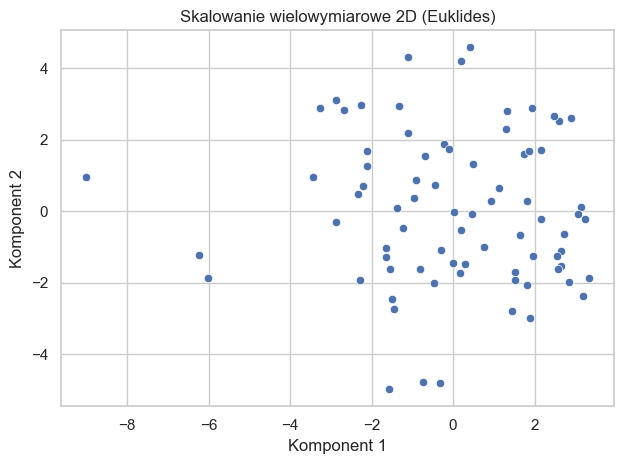

In [21]:
mds_euclidean = MDS(n_components=2, dissimilarity='euclidean', random_state=0)

mds_euclidean = mds_euclidean.fit_transform(data_train_final)

sns.scatterplot(x = mds_euclidean[:, 0], y = mds_euclidean[:, 1])
plt.title('Skalowanie wielowymiarowe 2D (Euklides)')
plt.xlabel('Komponent 1')
plt.ylabel('Komponent 2')
plt.tight_layout()
plt.show()

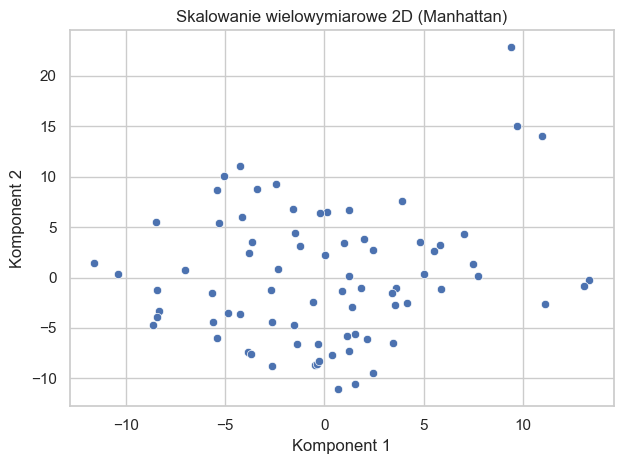

In [22]:
mds_manhattan = MDS(n_components=2, dissimilarity='precomputed', random_state=0)

mds_manhattan = mds_manhattan.fit_transform(squareform(pdist(data_train_final_robust, metric='cityblock')))

sns.scatterplot(x = mds_manhattan[:, 0], y = mds_manhattan[:, 1])
plt.title('Skalowanie wielowymiarowe 2D (Manhattan)')
plt.xlabel('Komponent 1')
plt.ylabel('Komponent 2')
plt.tight_layout()
plt.show()

W danych widoczne są wartości, które można uznać za odstające (albo klastry, z których obserwacje występują rzadko). Ma to miejsce w obu rozważanych przypadkach. Można tutaj tak czy inaczej wyodrębnić kilka klastrów. Ciężko jest określić ich liczbę.

### K-Means

Ma sens rozpocząć rozważania od klasteryzacji za pomocą k-średnich. W tym przypadku w celu wybrania liczby klastrów wykorzystano metodę łókcia oraz wskaźnik sylwetki.

In [23]:
metrics = ['SSE', 'Wskaźnik sylwetki']
metric_values = {metric : [] for metric in metrics}
cluster_nums = [i for i in range(2, 15)]
for i in cluster_nums:
    kmeans_temp = KMeans(n_clusters=i, random_state=0).fit(data_train_final)
    metric_values['SSE'].append(kmeans_temp.inertia_)
    metric_values['Wskaźnik sylwetki'].append(silhouette_score(data_train_final, kmeans_temp.labels_))

metric_df_kmeans = pd.DataFrame(metric_values)
metric_df_kmeans['Klastry'] = cluster_nums
display(metric_df_kmeans)

,SSE,Wskaźnik sylwetki,Klastry
0,621.882982,0.200940,2
1,528.616534,0.197944,3
2,468.101685,0.190344,4
3,380.845893,0.222729,5
4,303.557522,0.257435,6
5,267.354972,0.255608,7
6,258.418755,0.224169,8
7,249.997876,0.204448,9
8,237.218247,0.213042,10
9,225.567168,0.221913,11


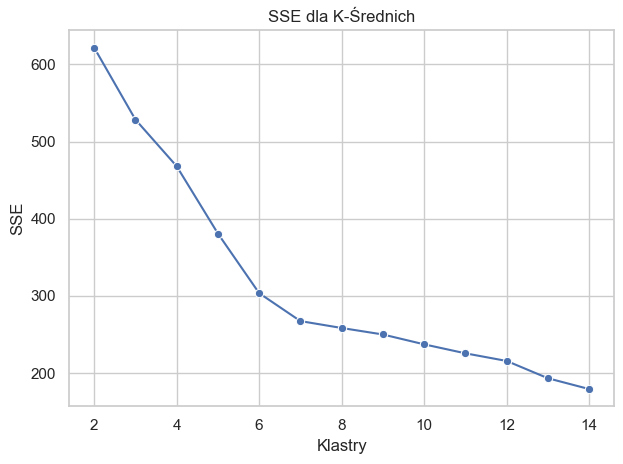

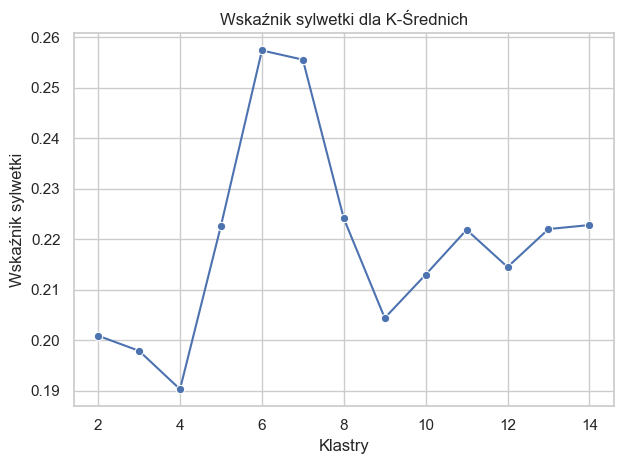

In [24]:
for metric in metrics:
    sns.lineplot(x='Klastry', y = metric, data = metric_df_kmeans, marker='o')
    plt.title(f'{metric} dla K-Średnich')
    plt.tight_layout()
    plt.show()

Oba wskaźniki wskazują na 6 klastrów.

In [25]:
k_means_labels = KMeans(n_clusters=6, random_state=0).fit(data_train_final).labels_

## K-Medoids

Klasteryzacja w przypadku K-medoid zostanie przeprowadzona w sposób analogiczny jak dla K-średnich.

In [26]:
def compute_manual_inertia(X, medoids, labels):
    distances = cdist(X, medoids, metric='cityblock')
    inertia = sum(distances[i, label] for i, label in enumerate(labels))
    return inertia

metrics = ['WCSD', 'Wskaźnik sylwetki']
metric_values = {metric : [] for metric in metrics}
cluster_nums = [i for i in range(2, 15)]
n_runs = 10

for i in cluster_nums:
    best_inertia = np.inf
    best_labels = None
    best_medoids = None

    for run in range(n_runs):
        kmedoids_temp = KMedoids(n_clusters=i, metric='manhattan', init='k-medoids++', random_state=run)
        kmedoids_temp.fit(data_train_final_robust)

        labels = kmedoids_temp.labels_
        medoid_indices = kmedoids_temp.medoid_indices_
        medoids = data_train_final_robust.iloc[medoid_indices]

        inertia = compute_manual_inertia(data_train_final_robust, medoids, labels)

        if inertia < best_inertia:
            best_inertia = inertia
            best_labels = labels
            best_medoids = medoids

    metric_values['WCSD'].append(best_inertia)
    silhouette = silhouette_score(data_train_final_robust, best_labels, metric='manhattan')
    metric_values['Wskaźnik sylwetki'].append(silhouette)

metric_df_kmedoids = pd.DataFrame(metric_values)
metric_df_kmedoids['Klastry'] = cluster_nums
display(metric_df_kmedoids)

,WCSD,Wskaźnik sylwetki,Klastry
0,515.224578,0.226066,2
1,468.419058,0.169910,3
2,432.772041,0.211587,4
3,404.157304,0.211839,5
4,380.782875,0.204291,6
5,360.008889,0.215117,7
6,343.343157,0.198526,8
7,328.285411,0.187991,9
8,306.087056,0.201396,10
9,286.021775,0.221298,11


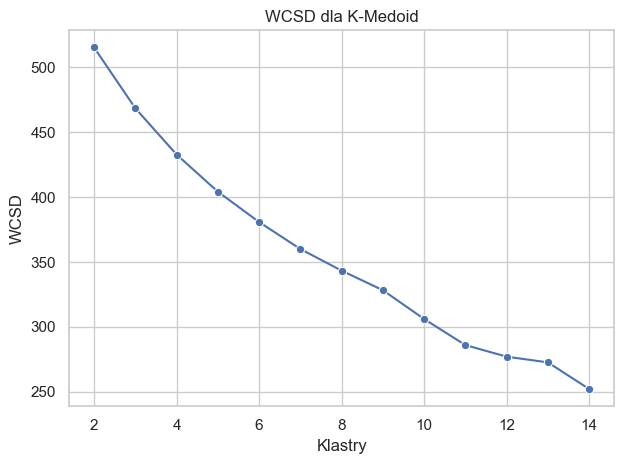

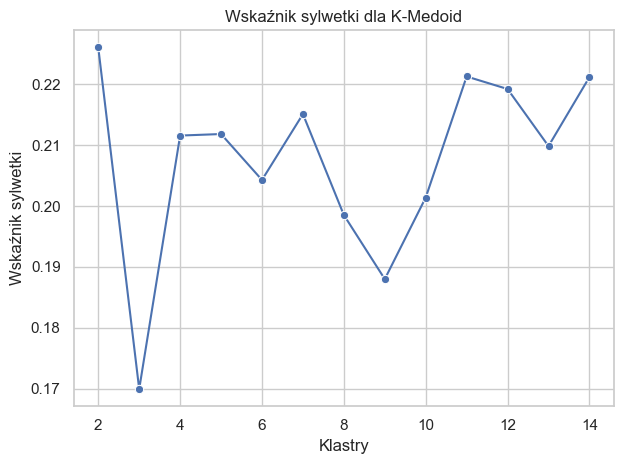

In [27]:
for metric in metrics:
    sns.lineplot(x='Klastry', y = metric, data = metric_df_kmedoids, marker='o')
    plt.title(f'{metric} dla K-Medoid')
    plt.tight_layout()
    plt.show()

Rozsądnie jest tutaj wybrać 2 klastry.

In [28]:
best_inertia = np.inf
k_medoids = None

for run in range(n_runs):
    kmedoids_temp = KMedoids(n_clusters=2, metric='manhattan', init='k-medoids++', random_state=run)
    kmedoids_temp.fit(data_train_final_robust)

    labels = kmedoids_temp.labels_
    medoid_indices = kmedoids_temp.medoid_indices_
    medoids = data_train_final_robust.iloc[medoid_indices]

    inertia = compute_manual_inertia(data_train_final_robust, medoids, labels)

    if inertia < best_inertia:
        best_inertia = inertia
        k_medoids = kmedoids_temp

k_medoids_labels = k_medoids.labels_

### Klasteryzacja aglomeracyjna

Rozsądnie będzie też zobaczyć jakie grupy uda się utworzyć za pomocą grupowania aglomeracyjnego. Została tutaj rozważona opcja zarówno łączenia Warda i odległości euklidesowej jak i łączenia najdalszego sąsiada i odległości Manhattan.

#### Odległość euklidesowa

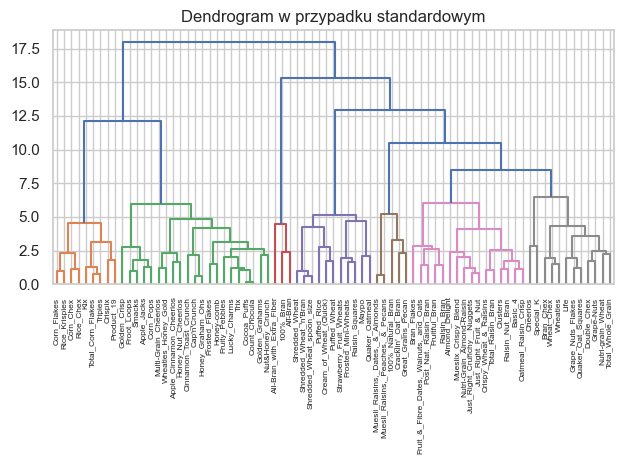

In [29]:
linkage_model_euclidean = linkage(data_train_final, method='ward', metric='euclidean')
dendrogram(linkage_model_euclidean, labels=data_train_final.index, color_threshold=7)
plt.title('Dendrogram w przypadku standardowym')
plt.tight_layout()
plt.show()

Rozsądnie będzie wybrać 7 grup, czyli uciąć dendrogram w wartości 7.

In [30]:
agg_labels_euclidean = fcluster(linkage_model_euclidean, 7, criterion='distance')

#### Odległość Manhattan

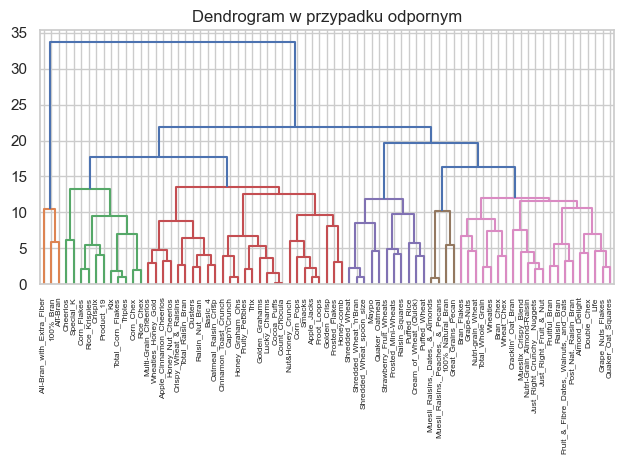

In [31]:
linkage_model_manhattan = linkage(data_train_final_robust, method='complete', metric='cityblock')
dendrogram(linkage_model_manhattan, labels=data_train_final_robust.index, color_threshold=14)
plt.title('Dendrogram w przypadku odpornym')
plt.tight_layout()
plt.show()

Tutaj rozsądnie jest podzielić zestaw danych na 6 grup, czyli uciąć dendrogram w wartości 14. 

In [32]:
agg_labels_manhattan = fcluster(linkage_model_manhattan, 14, criterion='distance')

### DBSCAN

W przypadku algorytmu klastrującego DBSCAN nie wybiera się liczby klastrów ale dostosowuje się hiperparametry, a algorytm sam na ich podstawie określa odpowiednią liczbę grup. *min_sample* został przyjęty jako 4. Epsilon zostanie dobrany na podstawie dystansu od 4-tego najbliższego sąsiada w zestawie danych.

#### Odległość euklidesowa

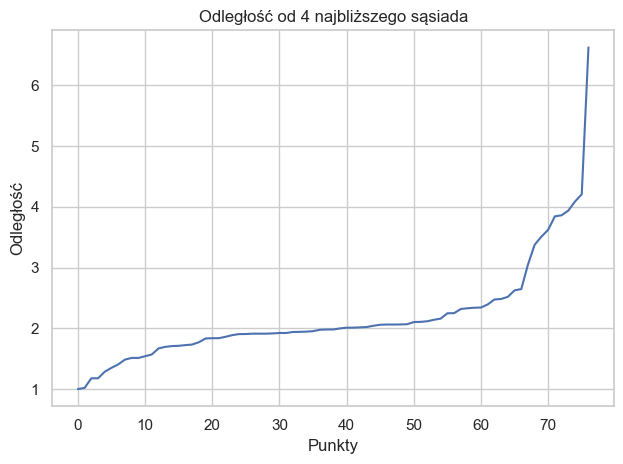

In [33]:
neighbors = NearestNeighbors(n_neighbors=4, metric='euclidean')
neighbors_fit = neighbors.fit(data_train_final)
distances, indices = neighbors_fit.kneighbors(data_train_final)

k_distances = np.sort(distances[:, -1])
plt.plot(k_distances)
plt.title('Odległość od 4 najbliższego sąsiada')
plt.xlabel('Punkty')
plt.ylabel('Odległość')
plt.tight_layout()
plt.show()

Rozsądna wydaje się być wartość 2.6.

In [34]:
dbscan_labels_euclidean = DBSCAN(eps=2.6, min_samples=4, metric='euclidean').fit(data_train_final).labels_

#### Odległość Manhattan

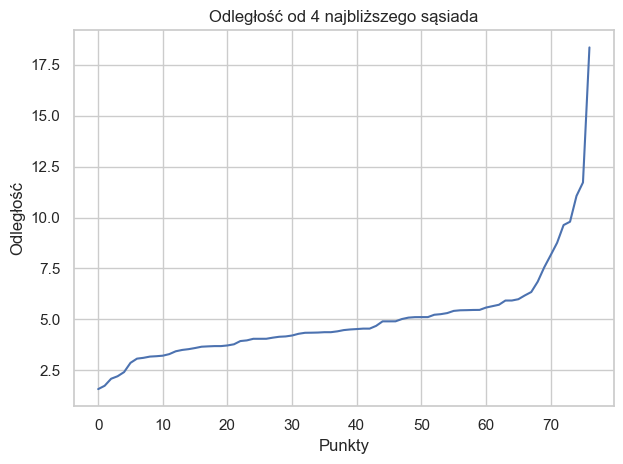

In [35]:
neighbors = NearestNeighbors(n_neighbors=4, metric='manhattan')
neighbors_fit = neighbors.fit(data_train_final_robust)
distances, indices = neighbors_fit.kneighbors(data_train_final_robust)

k_distances = np.sort(distances[:, -1])
plt.plot(k_distances)
plt.title('Odległość od 4 najbliższego sąsiada')
plt.xlabel('Punkty')
plt.ylabel('Odległość')
plt.tight_layout()
plt.show()

Dobra wartość to około 6.25.

In [36]:
dbscan_labels_manhattan = DBSCAN(eps=6.25, min_samples=4, metric='manhattan').fit(data_train_final_robust).labels_

## Wyniki

Zobrazowane teraz zostaną wyniki klasteryzacji z podziałem na metody standardowe (bazujące na danych zestandaryzowanych i odległości euklidesowej) oraz odporne (bazujące na danych znormalizowanych za pomocą IQR i odległości Manhattan). To jest koniec notebook-a. Wyniki zostaną zinterpretowane dokładnie w sprawozdaniu.

### Zobrazowanie wyników

Wyniki zobrazowane zostaną za pomocą skalowania wielowymiarowego wykonanego wcześniej.

#### Metody standardowe

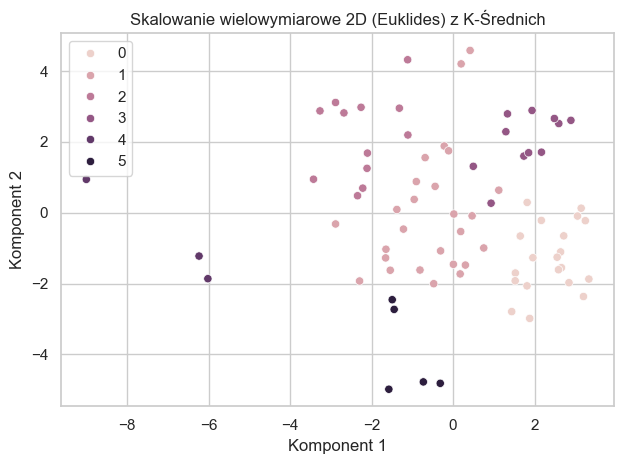

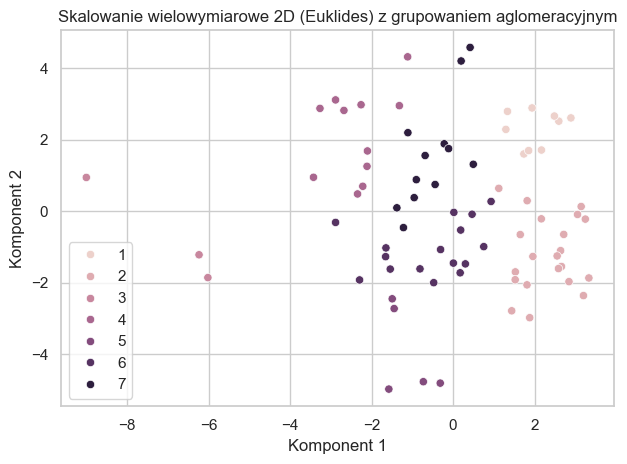

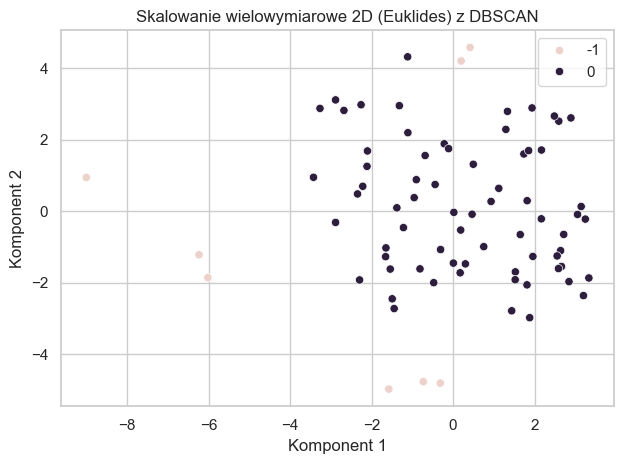

In [37]:
sns.scatterplot(x = mds_euclidean[:, 0], y = mds_euclidean[:, 1], hue = k_means_labels)
plt.title('Skalowanie wielowymiarowe 2D (Euklides) z K-Średnich')
plt.xlabel('Komponent 1')
plt.ylabel('Komponent 2')
plt.tight_layout()
plt.show()

sns.scatterplot(x = mds_euclidean[:, 0], y = mds_euclidean[:, 1], hue = agg_labels_euclidean)
plt.title('Skalowanie wielowymiarowe 2D (Euklides) z grupowaniem aglomeracyjnym')
plt.xlabel('Komponent 1')
plt.ylabel('Komponent 2')
plt.tight_layout()
plt.show()

sns.scatterplot(x = mds_euclidean[:, 0], y = mds_euclidean[:, 1], hue = dbscan_labels_euclidean)
plt.title('Skalowanie wielowymiarowe 2D (Euklides) z DBSCAN')
plt.xlabel('Komponent 1')
plt.ylabel('Komponent 2')
plt.tight_layout()
plt.show()

#### Metody odporne

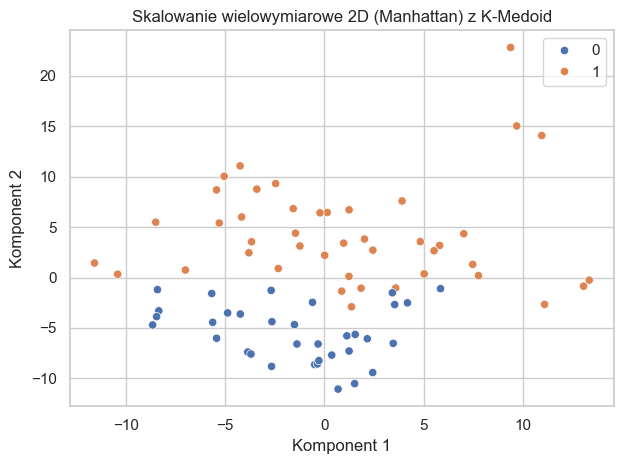

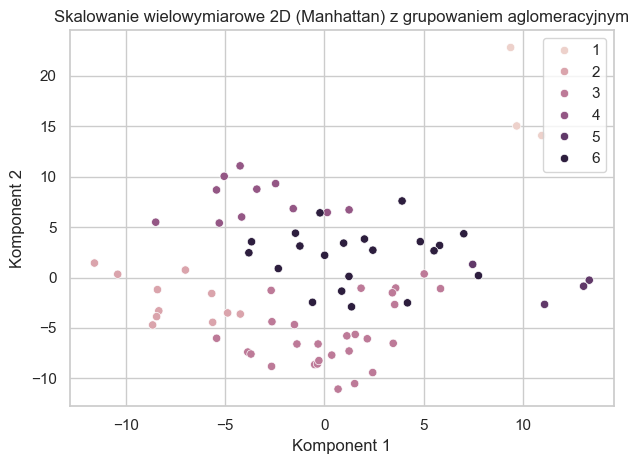

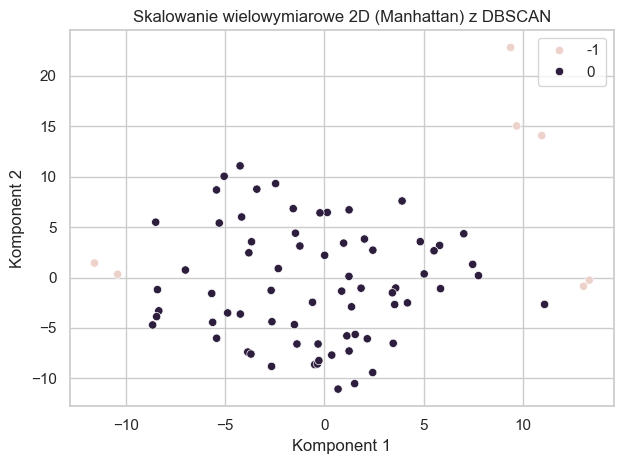

In [38]:
sns.scatterplot(x = mds_manhattan[:, 0], y = mds_manhattan[:, 1], hue = k_medoids_labels)
plt.title('Skalowanie wielowymiarowe 2D (Manhattan) z K-Medoid')
plt.xlabel('Komponent 1')
plt.ylabel('Komponent 2')
plt.tight_layout()
plt.show()

sns.scatterplot(x = mds_manhattan[:, 0], y = mds_manhattan[:, 1], hue = agg_labels_manhattan)
plt.title('Skalowanie wielowymiarowe 2D (Manhattan) z grupowaniem aglomeracyjnym')
plt.xlabel('Komponent 1')
plt.ylabel('Komponent 2')
plt.tight_layout()
plt.show()

sns.scatterplot(x = mds_manhattan[:, 0], y = mds_manhattan[:, 1], hue = dbscan_labels_manhattan)
plt.title('Skalowanie wielowymiarowe 2D (Manhattan) z DBSCAN')
plt.xlabel('Komponent 1')
plt.ylabel('Komponent 2')
plt.tight_layout()
plt.show()

### Wartości wskaźnika sylwetki

In [39]:
scores = [
    silhouette_score(data_train_final, k_means_labels),
    silhouette_score(data_train_final_robust, k_medoids_labels, metric='manhattan'),
    silhouette_score(data_train_final, agg_labels_euclidean),
    silhouette_score(data_train_final_robust, agg_labels_manhattan, metric='manhattan'),
    silhouette_score(data_train_final, dbscan_labels_euclidean),
    silhouette_score(data_train_final_robust, dbscan_labels_manhattan, metric='manhattan'),
]

data_scores = pd.DataFrame(
    {'Standad Model': scores[0::2],
     'Robust model': scores[1::2]},
    index=['K-Means/K-Medoids', 'Linkage', 'DBSCAN']
)

display(data_scores)

,Standad Model,Robust model
K-Means/K-Medoids,0.257435,0.226066
Linkage,0.245258,0.248617
DBSCAN,0.354252,0.375214


### Podsumowanie klastrów

Podsumowane zostaną centroidy jedynie dla k-Średnich w przypadku modeli standardowych. Wyniki dla metody Warda są podobne. W przypadku metod odpornych najlepiej wypadło klasterowanie aglomeracyjne, więc jego klastry też zostaną ukazane. 

#### K-Średnich

Przedstawione zostały centroidy.

In [40]:
k_means_summary = data_train.copy()

k_means_summary['cluster'] = k_means_labels

display(pd.DataFrame(k_means_summary['cluster'].value_counts().sort_index()))
display(pd.crosstab(k_means_summary['cluster'], k_means_summary['mfr'], margins=True, normalize='index'))
display(pd.crosstab(k_means_summary['cluster'], k_means_summary['shelf'], margins=True, normalize='index'))
display(k_means_summary.groupby('cluster')[numeric_cols_train].mean())

,count
cluster,
0,20
1,26
2,12
3,11
4,3
5,5


mfr,G,K,Other
cluster,,,
0,0.450000,0.300000,0.250000
1,0.384615,0.230769,0.384615
2,0.000000,0.250000,0.750000
3,0.272727,0.454545,0.272727
4,0.000000,0.666667,0.333333
5,0.000000,0.200000,0.800000
All,0.285714,0.298701,0.415584


shelf,1,2,3
cluster,,,
0,0.300000,0.700000,0.000000
1,0.230769,0.076923,0.692308
2,0.333333,0.333333,0.333333
3,0.363636,0.090909,0.545455
4,0.000000,0.000000,1.000000
5,0.000000,0.000000,1.000000
All,0.259740,0.272727,0.467532


,calories,protein,fat,sodium,fiber,carbo,sugars,potass,rating
cluster,,,,,,,,,
0,111.500000,1.500000,1.000000,170.000000,0.500000,12.500000,11.550000,43.750000,28.285363
1,100.437558,2.860996,1.095404,170.325614,2.603639,13.394791,6.298950,115.696445,42.616117
2,95.532129,3.034137,0.250000,22.083333,2.276205,18.275894,2.207454,99.789922,61.847551
3,107.272727,2.000000,0.363636,246.363636,0.454545,20.636364,3.272727,43.181818,41.482563
4,63.333333,4.000000,0.666667,176.666667,11.000000,6.666667,3.666667,310.000000,73.844463
5,130.000000,3.400000,3.400000,95.000000,3.000000,12.600000,8.200000,147.000000,38.304159


#### Metoda aglomeracyjna (odległość Manhattan)

Przedstawione zostały medoidy.

In [41]:
agg_summary_manhattan = data_train.copy()

agg_summary_manhattan['cluster'] = agg_labels_manhattan

display(pd.DataFrame(agg_summary_manhattan['cluster'].value_counts().sort_index()))
display(pd.crosstab(agg_summary_manhattan['cluster'], agg_summary_manhattan['mfr'], margins=True, normalize='index'))
display(pd.crosstab(agg_summary_manhattan['cluster'], agg_summary_manhattan['shelf'], margins=True, normalize='index'))
display(agg_summary_manhattan.groupby('cluster')[numeric_cols_train].mean())

,count
cluster,
1,3
2,11
3,27
4,11
5,4
6,21


mfr,G,K,Other
cluster,,,
1,0.000000,0.666667,0.333333
2,0.363636,0.454545,0.181818
3,0.592593,0.222222,0.185185
4,0.000000,0.181818,0.818182
5,0.000000,0.000000,1.000000
6,0.095238,0.380952,0.523810
All,0.285714,0.298701,0.415584


shelf,1,2,3
cluster,,,
1,0.000000,0.000000,1.000000
2,0.545455,0.090909,0.363636
3,0.259259,0.518519,0.222222
4,0.363636,0.363636,0.272727
5,0.000000,0.000000,1.000000
6,0.142857,0.095238,0.761905
All,0.259740,0.272727,0.467532


,calories,protein,fat,sodium,fiber,carbo,sugars,potass,rating
cluster,,,,,,,,,
1,63.333333,4.000000,0.666667,176.666667,11.000000,6.666667,3.666667,310.000000,73.844463
2,108.181818,2.727273,0.454545,260.909091,0.545455,20.454545,2.636364,45.000000,43.577271
3,108.706581,1.727987,1.102608,165.205978,0.884090,12.364216,10.568458,61.278567,30.302786
4,96.035049,3.037240,0.272727,8.636364,2.210405,18.300975,2.226313,100.679915,62.047980
5,135.000000,3.500000,3.500000,83.750000,2.750000,13.250000,8.500000,143.750000,37.768006
6,99.823754,2.653821,0.986194,167.519265,2.848770,14.020511,5.972587,117.075536,44.409567
